In [ ]:
"""

Date: April 30, 2024

Author: Karine Choquet

This script will perform analyses for the revisions of the Genome Research manuscript


"""

In [1]:
import numpy as np
import pandas as pd
import pysam
from collections import Counter

import matplotlib.pyplot as plt
import re
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import math

from tqdm import tqdm

import pybedtools
from pybedtools import BedTool

import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")

import scipy
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

import random
from numpy.random import choice

import itertools

import sklearn
from sklearn import decomposition
from sklearn.decomposition import PCA as PCA

from statsmodels.stats.multitest import multipletests

## Splicing order set up

In [3]:
# Load intron features and gene_names df
hg38_intron_df = pd.read_table("~/path/to/annotation_files/hg38_all_intron_features.txt")
gene_names_df = pd.read_table("~/path/to/annotation_files/hg38_UCSC_refGene_names.txt")
gene_names_df.columns = ['gene_name','gene_id']

hg38_intron_df['gene_id'] = hg38_intron_df['gene'].str.split("\\.").str[0]

hg38_intron_df = hg38_intron_df.merge(gene_names_df, on='gene_id')

hg38_intron_coord = hg38_intron_df.copy()[['chrom','start','end','gene','intron_pos']]

In [78]:
# Get all possible groups of 3 introns in the genome
sim_intron_list = []

for k in gene_dict.keys():
    # return all groups of 3 introns
    lst = gene_dict[k]
    consecutive_combinations = [lst[i:i+3] for i in range(len(lst)-2)]
    if len(consecutive_combinations) >= 1:
        for group in consecutive_combinations:
            group_str = "_".join([str(i) for i in group])
            sim_intron_list.append([k, group_str])

In [85]:
# Convert to dataframe
sim_intron_df = pd.DataFrame(sim_intron_list)
sim_intron_df.columns = ['gene','analyzed_introns']

In [86]:
# remove duplicate introns
sim_intron_df['int1'] = sim_intron_df['analyzed_introns'].str.split("_").str[0].astype(int)
sim_intron_df['int2'] = sim_intron_df['analyzed_introns'].str.split("_").str[1].astype(int)
sim_intron_df['int3'] = sim_intron_df['analyzed_introns'].str.split("_").str[2].astype(int)

sim_intron_df = sim_intron_df.merge(hg38_intron_coord, left_on=['gene','int1'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_1', 'start':'start_1', 'end':'end_1'})
sim_intron_df = sim_intron_df.merge(hg38_intron_coord, left_on=['gene','int2'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_2', 'start':'start_2', 'end':'end_2'})
sim_intron_df = sim_intron_df.merge(hg38_intron_coord, left_on=['gene','int3'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_3', 'start':'start_3', 'end':'end_3'})

sim_intron_df_nodup = sim_intron_df.sort_values(by=['gene','int1','int2','int3']).drop_duplicates(subset=['chrom_1','start_1','end_1','chrom_2','start_2','end_2','chrom_3','start_3','end_3']).reset_index(drop=True)

In [100]:
# Merge with gene name
sim_intron_df_nodup['gene_id'] = sim_intron_df_nodup['gene'].str.split("\\.").str[0]
sim_intron_df_nodup = sim_intron_df_nodup.merge(gene_names_df, on='gene_id')

In [104]:
# Get expression levels in LCLs from GTEx
gtex_tpm_tmp = pd.read_table("/path/to/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct")
gtex_tpm = gtex_tpm_tmp.copy()[['Name','Description','Cells - EBV-transformed lymphocytes']].drop_duplicates().reset_index(drop=True)

In [110]:
# Merge intron groups with expression levels and filter for >1TPM
sim_intron_df_gtex = sim_intron_df_nodup.merge(gtex_tpm, left_on='gene_name', right_on='Description')
sim_intron_df_gtex_filt = sim_intron_df_gtex[sim_intron_df_gtex['Cells - EBV-transformed lymphocytes']> 1].reset_index(drop=True)

In [112]:
# Calculate combined intronic length of the three introns in the group
sim_intron_df_gtex_filt['combined_intron_length'] = (sim_intron_df_gtex_filt['end_1'] - sim_intron_df_gtex_filt['start_1']) + (sim_intron_df_gtex_filt['end_2'] - sim_intron_df_gtex_filt['start_2']) + (sim_intron_df_gtex_filt['end_3'] - sim_intron_df_gtex_filt['start_3'])

In [118]:
# Get median and quantiles for the distribution of combined intron length
sim_intron_df_gtex_filt['combined_intron_length'].describe()

count    1.199360e+05
mean     1.443983e+04
std      3.024120e+04
min      4.000000e+00
25%      2.886000e+03
50%      6.500000e+03
75%      1.387425e+04
max      1.271612e+06
Name: combined_intron_length, dtype: float64

In [4]:
# Functions to remove duplicate introns from splicing order results
def remove_duplicate_introns(path_df_tmp):
    
    path_df = path_df_tmp[['cell_line','sample_name','rep','allele','gene','gene_name','analyzed_introns','n_analyzed_introns','full_path','full_path_score','rank']].drop_duplicates().sort_values(by=['gene_name','analyzed_introns','rank']).reset_index(drop=True)
    
    # Remove duplicates intron groups because they belong to different transcripts
    intron_groups = path_df[['gene','gene_name','analyzed_introns','n_analyzed_introns']].drop_duplicates().reset_index(drop=True)

    intron_groups_3 = intron_groups[intron_groups['n_analyzed_introns']==3].reset_index(drop=True)
    intron_groups_3['int1'] = intron_groups_3['analyzed_introns'].str.split("_").str[0].astype(int)
    intron_groups_3['int2'] = intron_groups_3['analyzed_introns'].str.split("_").str[1].astype(int)
    intron_groups_3['int3'] = intron_groups_3['analyzed_introns'].str.split("_").str[2].astype(int)

    intron_groups_3 = intron_groups_3.merge(hg38_intron_coord, left_on=['gene','int1'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_1', 'start':'start_1', 'end':'end_1'})
    intron_groups_3 = intron_groups_3.merge(hg38_intron_coord, left_on=['gene','int2'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_2', 'start':'start_2', 'end':'end_2'})
    intron_groups_3 = intron_groups_3.merge(hg38_intron_coord, left_on=['gene','int3'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_3', 'start':'start_3', 'end':'end_3'})

    intron_groups_3 = intron_groups_3.sort_values(by=['gene','int1','int2','int3']).drop_duplicates(subset=['chrom_1','start_1','end_1','chrom_2','start_2','end_2','chrom_3','start_3','end_3']).reset_index(drop=True)
    
    
    fields = ['gene','gene_name','analyzed_introns','n_analyzed_introns']
    intron_groups_nodup = intron_groups_3[fields].sort_values(by=['gene_name','analyzed_introns']).reset_index(drop=True)

    # Merge back with paths
    path_df_tmp_nodup = path_df_tmp.merge(intron_groups_nodup, on=['gene','gene_name','analyzed_introns','n_analyzed_introns'])
    path_df_nodup = path_df_tmp_nodup[['cell_line','sample_name','rep','allele','gene','gene_name','analyzed_introns','n_analyzed_introns','full_path','full_path_score','rank']].drop_duplicates().sort_values(by=['gene_name','analyzed_introns','rank']).reset_index(drop=True)
    
    return(path_df_nodup)

def remove_duplicate_introns_merged_reps(path_df_tmp):
    
    path_df = path_df_tmp[['cell_line','allele','gene','gene_name','analyzed_introns','n_analyzed_introns','full_path','full_path_score','rank']].drop_duplicates().sort_values(by=['gene_name','analyzed_introns','rank']).reset_index(drop=True)
    
    # Remove duplicates intron groups because they belong to different transcripts
    intron_groups = path_df[['gene','gene_name','analyzed_introns','n_analyzed_introns']].drop_duplicates().reset_index(drop=True)

    intron_groups_3 = intron_groups[intron_groups['n_analyzed_introns']==3].reset_index(drop=True)
    intron_groups_3['int1'] = intron_groups_3['analyzed_introns'].str.split("_").str[0].astype(int)
    intron_groups_3['int2'] = intron_groups_3['analyzed_introns'].str.split("_").str[1].astype(int)
    intron_groups_3['int3'] = intron_groups_3['analyzed_introns'].str.split("_").str[2].astype(int)

    intron_groups_3 = intron_groups_3.merge(hg38_intron_coord, left_on=['gene','int1'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_1', 'start':'start_1', 'end':'end_1'})
    intron_groups_3 = intron_groups_3.merge(hg38_intron_coord, left_on=['gene','int2'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_2', 'start':'start_2', 'end':'end_2'})
    intron_groups_3 = intron_groups_3.merge(hg38_intron_coord, left_on=['gene','int3'], right_on=['gene','intron_pos']).rename(columns={'chrom':'chrom_3', 'start':'start_3', 'end':'end_3'})

    intron_groups_3 = intron_groups_3.sort_values(by=['gene','int1','int2','int3']).drop_duplicates(subset=['chrom_1','start_1','end_1','chrom_2','start_2','end_2','chrom_3','start_3','end_3']).reset_index(drop=True)
    
    
    fields = ['gene','gene_name','analyzed_introns','n_analyzed_introns']
    intron_groups_nodup = intron_groups_3[fields].sort_values(by=['gene_name','analyzed_introns']).reset_index(drop=True)

    # Merge back with paths
    path_df_tmp_nodup = path_df_tmp.merge(intron_groups_nodup, on=['gene','gene_name','analyzed_introns','n_analyzed_introns'])
    path_df_nodup = path_df_tmp_nodup[['cell_line','allele','gene','gene_name','analyzed_introns','n_analyzed_introns','full_path','full_path_score','rank']].drop_duplicates().sort_values(by=['gene_name','analyzed_introns','rank']).reset_index(drop=True)
    
    return(path_df_nodup)


def get_distance_between_alleles(path_df):
    
    path_df_piv = path_df.pivot_table(index=['cell_line','sample_name','gene_name','gene','analyzed_introns','full_path'], columns='allele', values='full_path_score').reset_index().fillna(0)
    regions = path_df_piv[['cell_line','sample_name','gene','gene_name','analyzed_introns']].drop_duplicates().reset_index(drop=True)

    d_list = []

    for i in range(len(regions)):
        gene_name = regions.loc[i]['gene_name']
        gene = regions.loc[i]['gene']
        analyzed_introns = regions.loc[i]['analyzed_introns']
        cell_line = regions.loc[i]['cell_line']
        sample_name = regions.loc[i]['sample_name']
    
        df = path_df_piv[(path_df_piv['gene']==gene) & (path_df_piv['analyzed_introns']==analyzed_introns) & (path_df_piv['sample_name']==sample_name)].reset_index(drop=True)
        p1 = np.array(df['P'])
        p2 = np.array(df['M'])
    
        d = math.dist(p1, p2)
    
        d_list.append([cell_line,sample_name,gene_name,gene,analyzed_introns,d])
    
    d_df = pd.DataFrame(d_list)
    d_df.columns = ['cell_line','sample_name','gene_name','gene','analyzed_introns','d']
    
    both_df = path_df.merge(d_df, on=['cell_line','sample_name','gene_name','gene','analyzed_introns'])
    
    return(both_df)

def get_distance_between_alleles_merged_reps(path_df):
    
    path_df_piv = path_df.pivot_table(index=['cell_line','gene_name','gene','analyzed_introns','full_path'], columns='allele', values='full_path_score').reset_index().fillna(0)
    regions = path_df_piv[['cell_line','gene','gene_name','analyzed_introns']].drop_duplicates().reset_index(drop=True)

    d_list = []

    for i in range(len(regions)):
        gene_name = regions.loc[i]['gene_name']
        gene = regions.loc[i]['gene']
        analyzed_introns = regions.loc[i]['analyzed_introns']
        cell_line = regions.loc[i]['cell_line']
    
        df = path_df_piv[(path_df_piv['gene']==gene) & (path_df_piv['analyzed_introns']==analyzed_introns) & (path_df_piv['cell_line']==cell_line)].reset_index(drop=True)
        p1 = np.array(df['P'])
        p2 = np.array(df['M'])
    
        d = math.dist(p1, p2)
    
        d_list.append([cell_line,gene_name,gene,analyzed_introns,d])
    
    d_df = pd.DataFrame(d_list)
    d_df.columns = ['cell_line','gene_name','gene','analyzed_introns','d']
    
    both_df = path_df.merge(d_df, on=['cell_line','gene_name','gene','analyzed_introns'])
    
    return(both_df)


def get_distance_between_replicates(path_df_piv):
    
    regions = path_df_piv[['cell_line','allele','gene','gene_name','analyzed_introns']].drop_duplicates().reset_index(drop=True)

    d_list = []

    for i in range(len(regions)):
        gene_name = regions.loc[i]['gene_name']
        gene = regions.loc[i]['gene']
        analyzed_introns = regions.loc[i]['analyzed_introns']
        cell_line = regions.loc[i]['cell_line']
        allele = regions.loc[i]['allele']
    
        df = path_df_piv[(path_df_piv['gene']==gene) & (path_df_piv['analyzed_introns']==analyzed_introns) & (path_df_piv['allele']==allele) & (path_df_piv['cell_line']==cell_line)].reset_index(drop=True)
        p1 = np.array(df['rep1'])
        p2 = np.array(df['rep2'])
    
        d = math.dist(p1, p2)
    
        d_list.append([cell_line,allele,gene_name,gene,analyzed_introns,d])
    
    d_df = pd.DataFrame(d_list)
    d_df.columns = ['cell_line','allele','gene_name','gene','analyzed_introns','d']
        
    return(d_df)

In [5]:
# Get sample info
sample_info_tmp = pd.read_table("path/to/info.samples.new.txt", sep=",", header=None)
sample_info_tmp.columns = ['sample_name','cell_line','rep','compartment','device','kit']
sample_info = sample_info_tmp.copy()[['sample_name','cell_line','rep']]

## Chi-square test on partially spliced isoform counts (between replicates)

In [ ]:
# Initialize an empty list to store dataframes
df_list = []

# Loop over each sample name and read the corresponding file
for sample_name in sample_info['sample_name']:
    file_path = f"/path/to/{sample_name}_interm_counts_per_allele.hac.all_introns.min10reads.filterND.stringent.txt"
    df = pd.read_csv(file_path, sep="\t")
    df['sample_name'] = sample_name  # Add a new column for the sample name
    filt_df = sample_info[sample_info['sample_name']==sample_name].reset_index(drop=True)
    cell_line = filt_df.iloc[0]['cell_line']
    replicate = filt_df.iloc[0]['rep']
    df['cell_line'] = cell_line
    df['rep'] = replicate
    df_list.append(df)  # Append the dataframe to the list

# Concatenate all the dataframes into one
counts_df = pd.concat(df_list, ignore_index=True)

In [ ]:
# Pivot to have each replicate as one column
counts_df_piv = counts_df.pivot_table(index=['cell_line','gene_name','allele','gene','analyzed_introns','level','pattern2'],columns='rep', values='count_pattern2').reset_index()

# Extract samples with two replicates
two_reps_df = counts_df_piv[(~counts_df_piv['rep1'].isna()) & (~counts_df_piv['rep2'].isna()) & (~counts_df_piv['cell_line'].isin(['GM19102','GM19099','GM18870','GM19102']))].drop(columns='rep3')

# Extract samples with three replicates and format the same way as with two replicates
three_reps_df1_2 = counts_df_piv[(~counts_df_piv['rep1'].isna()) & (~counts_df_piv['rep2'].isna()) & (counts_df_piv['cell_line'].isin(['GM19102','GM19099','GM18870','GM19102']))].drop(columns='rep3')
three_reps_df1_3 = counts_df_piv[(~counts_df_piv['rep1'].isna()) & (~counts_df_piv['rep3'].isna()) & (counts_df_piv['cell_line'].isin(['GM19102','GM19099','GM18870','GM19102']))].drop(columns='rep2').rename(columns={'rep3':'rep2'})
three_reps_df2_3 = counts_df_piv[(~counts_df_piv['rep2'].isna()) & (~counts_df_piv['rep3'].isna()) & (counts_df_piv['cell_line'].isin(['GM19102','GM19099','GM18870','GM19102']))].drop(columns='rep1').rename(columns={'rep2':'rep1','rep3':'rep2'})

# Add a category
two_reps_df['category'] = '1_vs_2'
three_reps_df1_2['category'] = '1_vs_2'
three_reps_df1_3['category'] = '1_vs_3'
three_reps_df2_3['category'] = '2_vs_3'

# Concatenate all
reps_df = pd.concat([two_reps_df,three_reps_df1_2,three_reps_df1_3,three_reps_df2_3]).reset_index(drop=True)

In [ ]:
# Get list of intron groups
regions_df_ind = reps_df[['cell_line','gene_name','gene','analyzed_introns','category']].drop_duplicates().reset_index(drop=True)

In [ ]:
results_list = []

for i in tqdm(range(len(regions_df_ind))):
    
    cell_line = regions_df_ind.loc[i]['cell_line']
    gene_name = regions_df_ind.loc[i]['gene_name']
    gene = regions_df_ind.loc[i]['gene']
    analyzed_introns = regions_df_ind.loc[i]['analyzed_introns']
    category = regions_df_ind.loc[i]['category']
    
    # Retrieve the corresponding counts
    test_df = reps_df[(reps_df['cell_line']==cell_line) & (reps_df['gene_name']==gene_name) & (reps_df['gene']==gene) & (reps_df['analyzed_introns']==analyzed_introns) & (reps_df['category']==category)].reset_index(drop=True)
    test_df_piv_lev1 = test_df[test_df['level']==1].reset_index(drop=True)
    test_df_piv_lev2 = test_df[test_df['level']==2].reset_index(drop=True)
    
    sum_counts_lev1 = np.array(test_df_piv_lev1[['rep1','rep2']]).sum()
    sum_counts_lev2 = np.array(test_df_piv_lev2[['rep1','rep2']]).sum()
    
    pval1 = stats.chi2_contingency(np.array(test_df_piv_lev1[['rep1','rep2']]))[1]
    pval2 = stats.chi2_contingency(np.array(test_df_piv_lev2[['rep1','rep2']]))[1]
    
    results_list.append([cell_line,category,gene_name,gene,analyzed_introns,'level1',sum_counts_lev1,pval1])
    results_list.append([cell_line,category,gene_name,gene,analyzed_introns,'level2',sum_counts_lev2,pval2])
    
results_ind_df = pd.DataFrame(results_list)
results_ind_df.columns = ['cell_line','category','gene_name','gene','analyzed_introns','level','total_counts','pvalue']

# Correct for multiple testing
results_ind_df['FDR'] = multipletests(results_ind_df['pvalue'].astype(float), alpha=0.05, method='fdr_bh')[1]

In [ ]:
results_ind_df.to_csv("/path/to/results_files/LCLs_splicing_order_ind_reps_chisquare_test_results.txt", header=True, index=False, sep="\t")

## Chi-square test on partially spliced isoform counts (replicates merged)

In [6]:
# Get list of cell lines
cell_lines = sample_info['cell_line'].tolist()

# Initialize an empty list to store dataframes
df_list = []

# Loop over each sample name and read the corresponding file
for cell_line in cell_lines:
    file_path = f"/path/to/{cell_line}_chr_merged_interm_counts_per_allele.hac.all_introns.min10reads.filterND.stringent.txt"
    df = pd.read_csv(file_path, sep="\t")
    df['cell_line'] = cell_line  # Add a new column for the cell_line
    df_list.append(df)  # Append the dataframe to the list

# Concatenate all the dataframes into one
counts_merged_df = pd.concat(df_list, ignore_index=True)

In [7]:
# Get list of intron groups
regions_df = counts_merged_df[['cell_line','gene_name','gene','analyzed_introns']].drop_duplicates().reset_index(drop=True)

In [8]:
results_list = []

for i in tqdm(range(len(regions_df))):
    
    cell_line = regions_df.loc[i]['cell_line']
    gene_name = regions_df.loc[i]['gene_name']
    gene = regions_df.loc[i]['gene']
    analyzed_introns = regions_df.loc[i]['analyzed_introns']
    
    # Retrieve the corresponding counts
    test_df = counts_merged_df[(counts_merged_df['cell_line']==cell_line) & (counts_merged_df['gene_name']==gene_name) & (counts_merged_df['gene']==gene) & (counts_merged_df['analyzed_introns']==analyzed_introns)].reset_index(drop=True)
    test_df_piv = test_df.pivot_table(index=['level','pattern2'],columns='allele',values='count_pattern2').reset_index().fillna(0)
    test_df_piv_lev1 = test_df_piv[test_df_piv['level']==1].reset_index(drop=True)
    test_df_piv_lev2 = test_df_piv[test_df_piv['level']==2].reset_index(drop=True)
    
    sum_counts_lev1 = np.array(test_df_piv_lev1[['M','P']]).sum()
    sum_counts_lev2 = np.array(test_df_piv_lev2[['M','P']]).sum()
    
    pval1 = stats.chi2_contingency(np.array(test_df_piv_lev1[['M','P']]))[1]
    pval2 = stats.chi2_contingency(np.array(test_df_piv_lev2[['M','P']]))[1]
    
    results_list.append([cell_line,gene_name,gene,analyzed_introns,'level1',sum_counts_lev1,pval1])
    results_list.append([cell_line,gene_name,gene,analyzed_introns,'level2',sum_counts_lev2,pval2])
    
results_merged_df = pd.DataFrame(results_list)
results_merged_df.columns = ['cell_line','gene_name','gene','analyzed_introns','level','total_counts','pvalue']

# Correct for multiple testing
results_merged_df['FDR'] = multipletests(results_merged_df['pvalue'].astype(float), alpha=0.05, method='fdr_bh')[1]

100%|██████████| 16999/16999 [18:48<00:00, 15.06it/s]


In [9]:
# Get intron groups that are significant based on chi-square test
sig_by_counts = results_merged_df[results_merged_df['FDR']<0.05].reset_index(drop=True)

In [12]:
# Pivot results to have the results from each splicing level side by side
results_merged_df_piv = results_merged_df.pivot_table(index=['cell_line','gene_name','gene','analyzed_introns'], columns='level', values='FDR').reset_index()

In [ ]:
results_merged_df.to_csv("/path/to/LCLs_splicing_order_merged_reps_chisquare_test_results.txt", header=True, index=False, sep="\t")

## Euclidean distance with splicing orders (between replicates)

In [13]:
# Initialize an empty list to store dataframes
path_list = []

# Loop over each sample name and read the corresponding file
for sample_name in sample_info['sample_name']:
    file_path = f"/path/to/{sample_name}_splicing_order_paths_per_allele.hac.all_introns.min10reads.filterND.stringent.txt"
    df = pd.read_csv(file_path, sep="\t")
    df['sample_name'] = sample_name  # Add a new column for the sample name
    filt_df = sample_info[sample_info['sample_name']==sample_name].reset_index(drop=True)
    cell_line = filt_df.iloc[0]['cell_line']
    replicate = filt_df.iloc[0]['rep']
    df['cell_line'] = cell_line
    df['rep'] = replicate
    path_list.append(df)  # Append the dataframe to the list

# Concatenate all the dataframes into one
path_df_tmp = pd.concat(path_list, ignore_index=True)

In [14]:
# Remove duplicates and get distance between alleles within each sample
path_df_nodup = remove_duplicate_introns(path_df_tmp)
path_df_d = get_distance_between_alleles(path_df_nodup)

In [15]:
# Now calculate the Euclidean distance between alleles for the same replicate
path_df_piv = path_df_nodup.pivot_table(index=['cell_line','gene_name','allele','gene','analyzed_introns','full_path'],columns='rep', values='full_path_score').reset_index()

# Samples with two replicates
two_reps_df = path_df_piv[(~path_df_piv['rep1'].isna()) & (~path_df_piv['rep2'].isna()) & (~path_df_piv['cell_line'].isin(['GM19102','GM19099','GM18870','GM19102']))].drop(columns='rep3')
two_reps_d_df = get_distance_between_replicates(two_reps_df)

# Samples with three replicates
three_reps_df1_2 = path_df_piv[(~path_df_piv['rep1'].isna()) & (~path_df_piv['rep2'].isna()) & (path_df_piv['cell_line'].isin(['GM19102','GM19099','GM18870','GM19102']))].drop(columns='rep3')
three_reps_df1_3 = path_df_piv[(~path_df_piv['rep1'].isna()) & (~path_df_piv['rep3'].isna()) & (path_df_piv['cell_line'].isin(['GM19102','GM19099','GM18870','GM19102']))].drop(columns='rep2').rename(columns={'rep3':'rep2'})
three_reps_df2_3 = path_df_piv[(~path_df_piv['rep2'].isna()) & (~path_df_piv['rep3'].isna()) & (path_df_piv['cell_line'].isin(['GM19102','GM19099','GM18870','GM19102']))].drop(columns='rep1').rename(columns={'rep2':'rep1','rep3':'rep2'})
three_reps_d_df1_2 = get_distance_between_replicates(three_reps_df1_2)
three_reps_d_df1_3 = get_distance_between_replicates(three_reps_df1_3)
three_reps_d_df2_3 = get_distance_between_replicates(three_reps_df2_3)

# Concatenate all
reps_d_df = pd.concat([two_reps_d_df,three_reps_d_df1_2,three_reps_d_df1_3,three_reps_d_df2_3]).reset_index(drop=True)

In [16]:
# Get median distance per cell lines
reps_d_df.groupby('cell_line')['d'].median().sort_values()

cell_line
GM18522    0.072921
GM19209    0.080314
GM18861    0.087000
GM19099    0.090478
GM18853    0.095012
GM19102    0.096880
GM19223    0.097503
GM19152    0.100844
GM18501    0.101940
GM18870    0.102839
GM19144    0.117479
GM18510    0.124681
Name: d, dtype: float64

In [18]:
# Save distribution of Euclidean distance for plotting
reps_d_df.to_csv("/path/to/results_files/LCLs_splicing_order_distance_between_reps_all.txt", sep="\t", header=True, index=False)

In [19]:
# Calculate threshold = IQR * 1.5
my_threshold = reps_d_df['d'].quantile(0.75) + (1.5 * (reps_d_df['d'].quantile(0.75) - reps_d_df['d'].quantile(0.25)))
my_threshold

0.37893743510900685

## Euclidean distance on splicing orders from merged replicates

In [20]:
cell_lines = sample_info['cell_line'].drop_duplicates().tolist()

# Initialize an empty list to store dataframes
df_list = []

# Loop over each sample name and read the corresponding file
for cell_line in cell_lines:
    file_path = f"/path/to/{cell_line}_chr_merged_splicing_order_paths_per_allele.hac.all_introns.min10reads.filterND.stringent.txt"
    df = pd.read_csv(file_path, sep="\t")
    df['cell_line'] = cell_line  # Add a new column for the cell_line
    df_list.append(df)  # Append the dataframe to the list

# Concatenate all the dataframes into one
path_merged_df = pd.concat(df_list, ignore_index=True)

In [21]:
# Remove duplicates and get distance between alleles within each sample
path_df_merged_nodup = remove_duplicate_introns_merged_reps(path_merged_df)
path_df_merged_d = get_distance_between_alleles_merged_reps(path_df_merged_nodup)

In [22]:
# Merge results from chi-square and from Euclidean distance
test_df = path_df_merged_d.merge(results_merged_df_piv, on=['cell_line','gene','gene_name','analyzed_introns'])
test_df_sig = test_df[((test_df['level1']<0.05) | (test_df['level2']<0.05)) & (test_df['d']>=my_threshold)][['cell_line','gene','gene_name','analyzed_introns','level1','level2','d']].drop_duplicates().reset_index(drop=True)

In [28]:
# Save results for further plotting in R
test_df.to_csv("/path/to/results_files/LCLs_splicing_order_merged_samples_chi_square_vs_distance_results.txt", header=True, index=False, sep="\t")


## Modify DRIMSeq genotypes file

In [31]:
# Get file with genotypes that were used as input for DRIMseq tuQTL
geno_df = pd.read_table("/path/to/LCLs_studied_cell_lines.genes_splicing_order.extended.formatted_for_drimseq.txt")

In [29]:
# Get results from DRIMSeq tuQTL and filter for significant SNPs
drim_df = pd.read_table("/path/to/drimseq_tuQTL._filtered_min2_sig_cell_lines_window500.tsv")
drim_snps = drim_df[drim_df['adj_pvalue']<0.05].reset_index(drop=True)


In [32]:
# Get a list of SNPs that were significant
geno_df_sub = geno_df[geno_df['ID'].isin(drim_snps['snp_id'].tolist())].reset_index(drop=True)

In [33]:
# Reformat the genotype file so that it's in long format
geno_df_m = geno_df_sub.melt(id_vars=['CHROM','START','ID','REF','ALT'], var_name='allele', value_name='genotype')

In [34]:
# Save for plotting in R
geno_df_m.to_csv("/path/to/results_files/DRIMseq_tuQTL_sig_snps.iltered_min2_sig_cell_lines_window500.with_genotypes.txt", sep="\t", header=True, index=False)

## Intron pairs (merged replicates)

In [35]:
# Get intron pairs counts
cell_lines = sample_info['cell_line'].drop_duplicates().tolist()

# Initialize an empty list to store dataframes
df_list = []

# Loop over each sample name and read the corresponding file
for cell_line in cell_lines:
    file_path = f"/path/to/{cell_line}_chr_merged_hg38_intron_pairs_counts.txt"
    df = pd.read_csv(file_path, sep="\t")
    df['cell_line'] = cell_line  # Add a new column for the cell_line
    df_list.append(df)  # Append the dataframe to the list

# Concatenate all the dataframes into one
pairs_counts_df = pd.concat(df_list, ignore_index=True).sort_values(by=['cell_line','gene_name','gene','int1_count','int2_count','allele','splice_order']).reset_index(drop=True)

In [36]:
# Get unique pairs
pairs_regions_df = pairs_counts_df[['cell_line','gene_name','gene','int1_count','int2_count']].drop_duplicates().reset_index(drop=True)

In [51]:
# Get all pairs genes
pairs_genes = pairs_regions_df['gene'].drop_duplicates()

In [52]:
# For each intron pair in each cell line, compare splicing order between alleles using a Fisher's exact test
pairs_list = []

for i in tqdm(range(len(pairs_regions_df))):
    
    cell_line = pairs_regions_df.loc[i]['cell_line']
    gene_name = pairs_regions_df.loc[i]['gene_name']
    gene = pairs_regions_df.loc[i]['gene']
    int1 = pairs_regions_df.loc[i]['int1_count']
    int2 = pairs_regions_df.loc[i]['int2_count']
    
    # Retrieve the corresponding counts
    test_df = pairs_counts_df[(pairs_counts_df['cell_line']==cell_line) & (pairs_counts_df['gene_name']==gene_name) & (pairs_counts_df['gene']==gene) & (pairs_counts_df['int1_count']==int1) & (pairs_counts_df['int2_count']==int2)].reset_index(drop=True)
    test_df_piv = test_df.pivot_table(index=['splice_order'],columns='allele',values='read').reset_index().fillna(0).sort_values(by='splice_order').reset_index(drop=True)
    
    if len(test_df_piv) == 2: # if both splicing orders are seen on at least one allele
        sum_counts = np.array(test_df_piv[['M','P']]).sum()
        counts_in_order_M = test_df_piv.loc[0]['M']
        counts_in_order_P = test_df_piv.loc[0]['P']
        counts_out_order_M = test_df_piv.loc[1]['M']
        counts_out_order_P = test_df_piv.loc[1]['P']
        in_order_P = test_df_piv.loc[0]['P'] / (test_df_piv.loc[1]['P'] + test_df_piv.loc[0]['P']) 
        in_order_M = test_df_piv.loc[0]['M'] / (test_df_piv.loc[1]['M'] + test_df_piv.loc[0]['M'])
        delta = in_order_M - in_order_P
        pval = stats.fisher_exact(np.array(test_df_piv[['M','P']]))[1]
        pairs_list.append([cell_line,gene_name,gene,int1,int2,sum_counts,counts_in_order_M,counts_out_order_M,counts_in_order_P,counts_out_order_P,in_order_M,in_order_P,delta,pval])
    
    elif len(test_df_piv) > 2:
        print(gene, cell_line, int1, int2, "something weird")
    
pairs_df = pd.DataFrame(pairs_list)
pairs_df.columns = ['cell_line','gene_name','gene','int1_count','int2_count','total_counts','counts_in_order_M','counts_out_order_M','counts_in_order_P','counts_out_order_P','in_order_M','in_order_P','delta','pvalue']

# Correct for multiple testing
pairs_df['FDR'] = multipletests(pairs_df['pvalue'].astype(float), alpha=0.05, method='fdr_bh')[1]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58322/58322 [17:25<00:00, 55.79it/s]


In [53]:
# Save results for further processing in R
pairs_df.to_csv("/path/to/results_files/LCLs_splicing_order_merged_samples_intron_pairs_Fisher_exact_test_results.txt", header=True, index=False, sep="\t")


## HLA-B splicing order heatmap

In [48]:
# Load VCF files with genotypes
vcf_test_all = pd.read_table("/path/to/LCLs_studied_cell_lines_all_SNPs.genes_splicing_order.extended.vcf", header=None)
vcf_test_het = pd.read_table("/path/to/LCLs_studied_cell_lines_het_SNPs_phased.genes_splicing_order.extended.vcf", header=None)

vcf_test_all.columns = ["CHROM","START","ID","REF","ALT","QUAL","FILTER","INFO","FORMAT","GM19102","GM19099","GM18870","GM19223","GM18501","GM18510","GM18853","GM19144","GM19152","GM18522","GM18861","GM19209"]
vcf_test_het.columns = ["CHROM","START","ID","REF","ALT","QUAL","FILTER","INFO","FORMAT","GM18870","GM19099","GM19102","GM19223","GM18501","GM18510","GM18853","GM19144","GM19152","GM18522","GM18861","GM19209"]

vcf_test_all['Type'] = 'hom'
vcf_test_het['Type'] = 'het'

# Define the list of cell lines
sample_list = ["GM19102","GM19099","GM18870","GM19223","GM18501","GM18510","GM18853","GM19144","GM19152","GM18522","GM18861","GM19209"]

# Reformat VCF files for the two types of genotypes and combine them
vcf_test_hom = vcf_test_all.drop(columns=['QUAL','FILTER','INFO','FORMAT']).melt(id_vars=["CHROM","START","ID","REF","ALT","Type"],value_vars=sample_list, var_name='cell_line',value_name='genotype')
vcf_test_hom = vcf_test_hom[vcf_test_hom['genotype'].isin(['0|0','1|1'])].reset_index(drop=True)
vcf_test_het = vcf_test_het.drop(columns=['QUAL','FILTER','INFO','FORMAT']).melt(id_vars=["CHROM","START","ID","REF","ALT","Type"],value_vars=sample_list, var_name='cell_line',value_name='genotype')
vcf_test_het = vcf_test_het[vcf_test_het['genotype'].isin(['0|1','1|0'])].reset_index(drop=True)
vcf_test = pd.concat([vcf_test_hom,vcf_test_het]).reset_index(drop=True)

In [57]:
# HLA-B coordinates
gene_start = 31353875
gene_end = 31357179

# Extract SNPs located within HLA-B
vcf_test_sub = vcf_test[(vcf_test['START']>gene_start) & (vcf_test['START']<gene_end)].reset_index(drop=True)


In [58]:
# Separate alleles
vcf_test_sub['P'] = vcf_test_sub['genotype'].str.split("\\|").str[0].astype(int)
vcf_test_sub['M'] = vcf_test_sub['genotype'].str.split("\\|").str[1].astype(int)

In [59]:
# Reformat and name allele based on cell line and parental origin
vcf_test_bis = vcf_test_sub.melt(id_vars=['cell_line','ID','CHROM','START','REF','ALT'], value_vars=['P','M'], var_name='allele_tmp', value_name='geno')
vcf_test_bis['allele'] = vcf_test_bis['cell_line'] + '_' + vcf_test_bis['allele_tmp']

In [79]:
# Make a matrix with HLA-B genotypes
mat_HLAB = vcf_test_bis.sort_values(by='START').pivot_table(index=["START"], columns='allele', values="geno")

# Eliminate rows where all samples have same genotype, and the three cell lines that could not be analyzed in allele-specific manner for splicing order
mat_HLAB['sum_geno'] = mat_HLAB.sum(axis=1)
mat_HLAB = mat_HLAB[(mat_HLAB['sum_geno']>0) & (mat_HLAB['sum_geno']<16)].drop(columns=['sum_geno','GM19099_P','GM19099_M','GM19223_P','GM19223_M','GM18853_P','GM18853_M']).dropna()
# Transpose matrix
mat_HLAB_rev = mat_HLAB.T

In [86]:
# Cluster alleles based on genotypes
linkage_paths = scipy.cluster.hierarchy.linkage(mat_HLAB_rev, method="average")

In [99]:
# Get splicing orders
path_df = pd.read_table("/path/to/results_files/LCLs_splicing_order_merged_samples_chi_square_vs_distance_results.txt")
path_df['allele_bis'] = path_df['cell_line'] + '_' + path_df['allele']

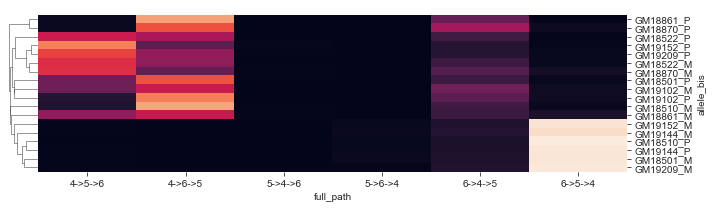

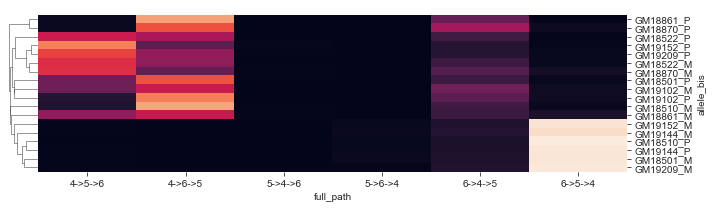

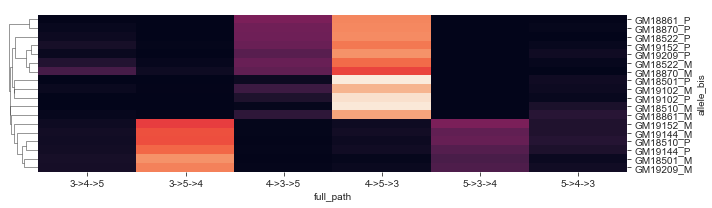

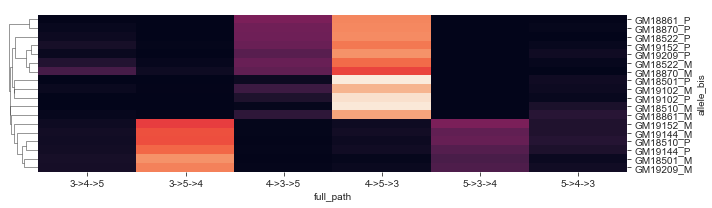

In [91]:
# Plot heatmap of splicing orders for each intron group of interest
intron_groups = ['6_5_4','5_4_3']

for analyzed_introns in intron_groups:
    path_mat = path_df[(path_df['gene_name']=="HLA-B") & (path_df['analyzed_introns']==analyzed_introns)].pivot_table(index="full_path", columns="allele_bis", values="full_path_score").fillna(0)
    path_mat_rev = path_mat.T
    out_name = "/path/to/Figures/plots/Fig5_heatmap_splicing_order_scores_HLA-B_introns" + analyzed_introns + ".pdf"
    
    if len(path_mat_rev) == len(mat_HLAB_rev):
        cm = sns.clustermap(path_mat_rev, yticklabels=True, xticklabels=True, figsize=(10,3), col_cluster=False, 
                    row_linkage=linkage_paths, dendrogram_ratio=0.05)

        cm.cax.set_visible(False)
    

        cm = sns.clustermap(path_mat_rev, yticklabels=True, xticklabels=True, figsize=(10,3), col_cluster=False, 
                    row_linkage=linkage_paths, dendrogram_ratio=0.05)

        cm.cax.set_visible(False)
        
        plt.savefig(out_name, format='pdf', dpi=300, bbox_inches='tight')
